In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import geopandas as gpd
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [7]:
ds = xr.open_dataset('./data/dataset_complete_for_model_CO.nc')
ds

<xarray.Dataset>
Dimensions:            (latitude: 33, longitude: 33, time: 744)
Coordinates:
  * time               (time) datetime64[ns] 2019-05-01 ... 2019-05-31T23:00:00
  * latitude           (latitude) float64 43.0 43.25 43.5 ... 50.5 50.75 51.0
  * longitude          (longitude) float64 4.0 4.25 4.5 4.75 ... 11.5 11.75 12.0
Data variables: (12/32)
    EMISSIONS_2019     (latitude, longitude, time) float64 ...
    u10                (latitude, longitude, time) float64 ...
    v10                (latitude, longitude, time) float64 ...
    hcc                (latitude, longitude, time) float64 ...
    lcc                (latitude, longitude, time) float64 ...
    tcc                (latitude, longitude, time) float64 ...
    ...                 ...
    CO2_tc_add_trend   (latitude, longitude, time) float64 ...
    CH4_tc_add_trend   (latitude, longitude, time) float64 ...
    NO2_tc_add_trend   (latitude, longitude, time) float64 ...
    CO_tc_add_trend    (latitude, longitude, time) float64 ...
    O3_tc_add_trend    (latitude, longitude, time) float64 ...
    traffic            (latitude, longitude, time) float64 ...

In [8]:
d = ds[['EMISSIONS_2019', 'tcc','sp','tmp','rel_hum','tot_wind','built','NO_tc', 'O3_tc', 'traffic']]

In [10]:
top = ds.EMISSIONS_2019.mean('time').to_dataframe()
top.sort_values(by='EMISSIONS_2019', ascending=False)

EMISSIONS_2019
latitude longitude                
43.00    10.50        4.371319e-09
51.00    6.50         1.478115e-09
49.25    7.00         1.023982e-09
         6.75         8.743603e-10
51.00    7.00         8.461958e-10
...                            ...
43.00    4.25         3.486412e-13
46.25    9.50         1.835723e-13
45.75    6.75         1.546607e-13
46.50    9.00         1.339379e-13
         8.00         7.172251e-14

[1089 rows x 1 columns]

In [8]:
em = ds.EMISSIONS_2019

In [9]:
out = []
for i in em.dropna(dim='time').time.values:
    em_ = em.sel(time=i)

    val = em_.where(em_==em_.max(), drop=True).squeeze().values
    lat = em_.where(em_==em_.max(), drop=True).squeeze().latitude.values
    lon = em_.where(em_==em_.max(), drop=True).squeeze().longitude.values
    
    val_ = sorted(np.ravel(em_))[-2]
    val2 = em_.where(em_==val_, drop=True).squeeze().values
    lat2 = em_.where(em_==val_, drop=True).squeeze().latitude.values
    lon2 = em_.where(em_==val_, drop=True).squeeze().longitude.values

    
    out.append((i, lat, lon, val, lat2, lon2, val2))

In [153]:
df = pd.DataFrame(out, columns=['time', 'lat', 'lon', 'max', 'lat2', 'lon2', 'max2'])
df['coords'] = df.lat.astype('str') + ' ' + df.lon.astype('str')
df['max'] = df['max'].astype('float')
df['max2'] = df['max2'].astype('float')
df.head()

,time,lat,lon,max,lat2,lon2,max2,coords
0,2019-05-01 01:00:00,43.0,10.5,1.673723e-09,51.0,6.5,4.934406e-10,43.0 10.5
1,2019-05-01 02:00:00,43.0,10.5,1.613947e-09,51.0,6.5,4.317605e-10,43.0 10.5
2,2019-05-01 03:00:00,43.0,10.5,1.613947e-09,51.0,6.5,4.163405e-10,43.0 10.5
3,2019-05-01 04:00:00,43.0,10.5,1.733499e-09,51.0,6.5,4.163405e-10,43.0 10.5
4,2019-05-01 05:00:00,43.0,10.5,2.510584e-09,45.5,12.0,5.036520e-10,43.0 10.5


In [156]:
df.groupby('coords').count()

,time,lat,lon,max,lat2,lon2,max2,diff
coords,,,,,,,,
43.0 10.5,701,701,701,701,701,701,701,701
51.0 6.5,19,19,19,19,19,19,19,19


<AxesSubplot:>

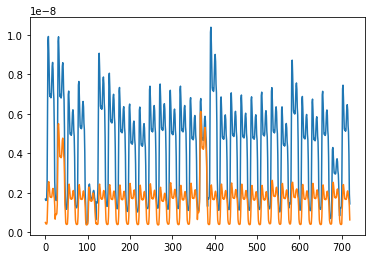

In [154]:
df['diff'] = (df['max'] / df['max2'])
df['max'].plot()
ax = plt.gca()
df['max2'].plot(ax=ax)

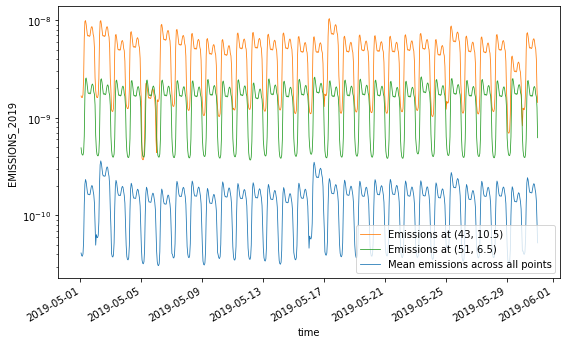

In [27]:
em.sel(latitude=43, longitude=10.5).plot(c='C1', lw=0.8, label='Emissions at (43, 10.5)')
em.sel(latitude=51, longitude=6.5).plot(c='C2', lw=0.8, label='Emissions at (51, 6.5)')
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(9,5)
em.mean(['latitude', 'longitude']).plot(c='C0', lw=0.8, ax=ax, label='Mean emissions across all points')
plt.legend()
ax.set_yscale('log')
plt.savefig('outputs/outlier.png', dpi=240)

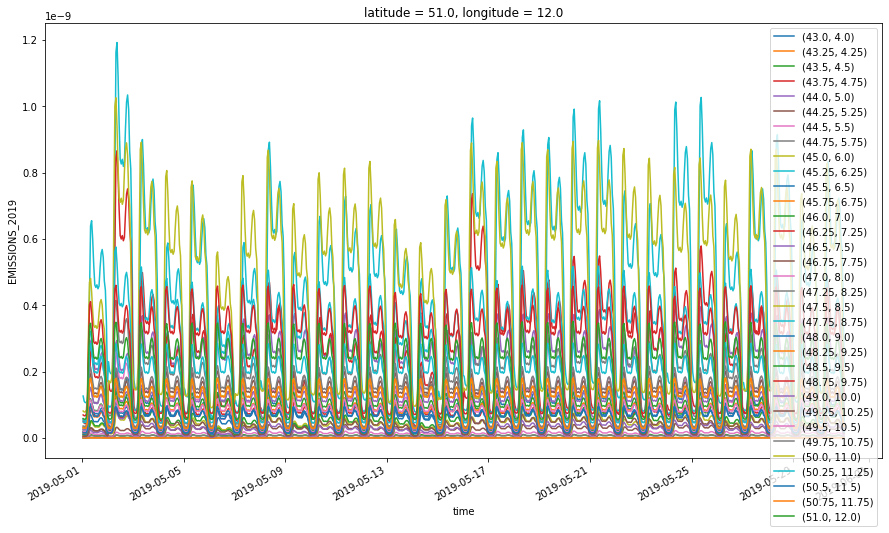

In [63]:
fig, ax = plt.subplots(1,1, figsize=(15,8))

for i,j in zip(ds.EMISSIONS_2019.latitude.values, ds.EMISSIONS_2019.longitude.values):
    toPlot = ds.EMISSIONS_2019.sel(latitude=i, longitude=j)
    toPlot.plot(ax=ax, label=(i,j))
plt.legend()

In [4]:
da = ds.groupby(ds.time.dt.hour).mean()

In [5]:
milan = da[['traffic', 'EMISSIONS_2019']].sel(longitude=9.25, latitude=45.5,).to_dataframe()
rural = da[['traffic', 'EMISSIONS_2019']].sel(longitude=8.00, latitude=44.00).to_dataframe()

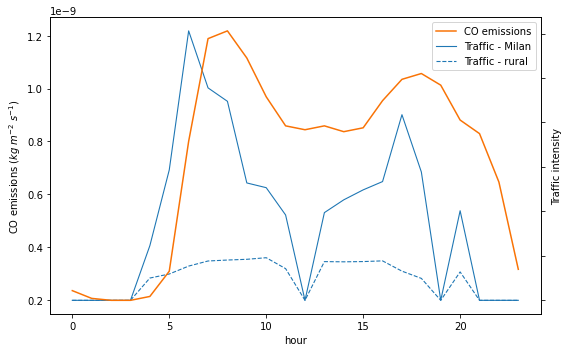

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

milan.EMISSIONS_2019.plot(ax=ax, c='xkcd:orange', label='CO emissions')

ax_ = ax.twinx()
ax.set_ylabel('CO emissions ($kg \; m^{-2} \; s^{-1}$)')
ax_.set_ylabel('Traffic intensity')
ax_.set_zorder(-1)  # default zorder is 0 for ax1 and ax2
ax.patch.set_visible(False)

milan.traffic.plot(ax=ax_, c='C0', linestyle='-', linewidth=1.1, label='Traffic - Milan', zorder=-10)
rural.traffic.plot(ax=ax_, c='C0', linestyle='--', linewidth=1.1, label='Traffic - rural', zorder=-10)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax_.get_legend_handles_labels()
ax_.set_yticklabels([])

plt.legend(handles=h1+h2, labels=l1+l2)

plt.tight_layout()
# plt.savefig('./outputs/traffic_emissions_comparison.png', dpi=240)

___

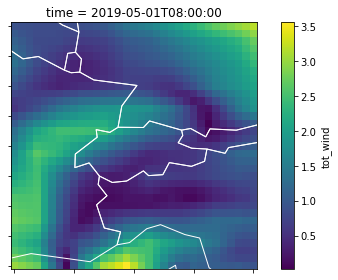

In [15]:
ds.tot_wind.isel(time=8).plot()
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel(None)
ax.set_ylabel(None)
fig = plt.gcf()
fig.set_size_inches(7,4)
countries.plot(ax=ax, fc='None', ec='white', zorder=1)
plt.tight_layout()
# plt.savefig('outputs/built.png', dpi=240)

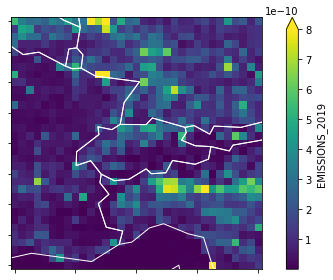

In [16]:
ds.EMISSIONS_2019.mean('time').plot(vmax=8e-10)
fig = plt.gcf()
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel(None)
ax.set_ylabel(None)
fig.set_size_inches(7,4)
countries.plot(ax=ax, fc='None', ec='white', zorder=1)
plt.tight_layout()
# plt.savefig('outputs/emissions.png', dpi=240)

/opt/conda/envs/machine-learning/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/machine-learning/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


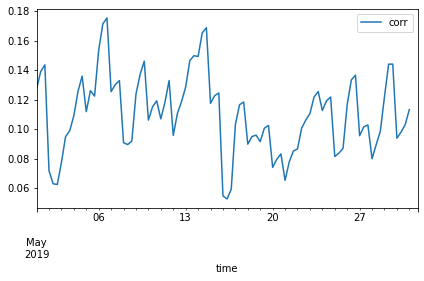

In [18]:
corr_df = xr.corr(ds.EMISSIONS_2019, ds.sp, dim=['latitude', 'longitude']).to_dataframe(name='corr')
corr_df.resample('8H').mean().plot()
plt.tight_layout()
# plt.savefig('outputs/pressure_emissions_corr.png', dpi=240)

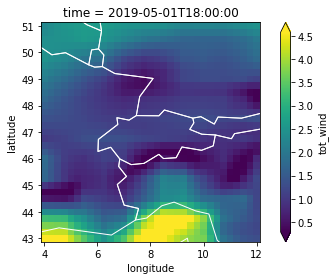

In [20]:
ds.tot_wind.isel(time=18).plot(robust=True)
ax = plt.gca()
countries.plot(ax=ax, fc='None', ec='white', zorder=1)
plt.tight_layout()

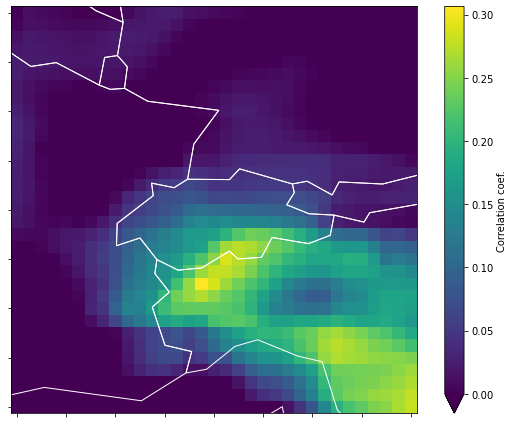

In [50]:
corr_df = xr.corr(ds.CO_tc, ds.EMISSIONS_2019, dim=['time'])
corr_df.plot(vmin=0, cmap='viridis', cbar_kwargs={'label':'Correlation coef.'})#.groupby(corr_df.index.hour).mean().plot()
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel(None)
ax.set_ylabel(None)
fig = plt.gcf()
fig.set_size_inches(8,6)
countries.plot(ax=ax, fc='None', ec='white', zorder=1)
plt.tight_layout()
plt.savefig('outputs/CO_emissions_corr.png', dpi=240)

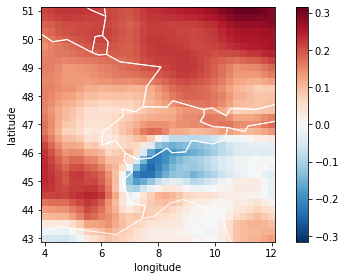

In [22]:
xr.corr(ds.tot_wind, ds.EMISSIONS_2019, dim=['time']).plot()
ax = plt.gca()
countries.plot(ax=ax, fc='None', ec='white', zorder=1)
plt.tight_layout()

In [65]:
df = ds[['EMISSIONS_2019', 'NO_tc']].mean(['latitude', 'longitude']).to_dataframe().dropna()
# df = ds[['EMISSIONS_2019', 'NO_tc']].isel(latitude=15, longitude=10)#.to_dataframe().dropna()

df

,EMISSIONS_2019,NO_tc
time,,
2019-05-01 01:00:00,4.126808e-11,3.179515e-07
2019-05-01 02:00:00,3.867574e-11,5.594578e-07
2019-05-01 03:00:00,3.828428e-11,8.010452e-07
2019-05-01 04:00:00,4.033721e-11,1.042633e-06
2019-05-01 05:00:00,5.446423e-11,1.284220e-06
...,...,...
2019-05-30 08:00:00,2.439935e-10,1.492181e-06
2019-05-30 09:00:00,2.315678e-10,1.555217e-06
2019-05-30 10:00:00,2.047178e-10,1.618151e-06


/opt/conda/envs/machine-learning/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/machine-learning/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


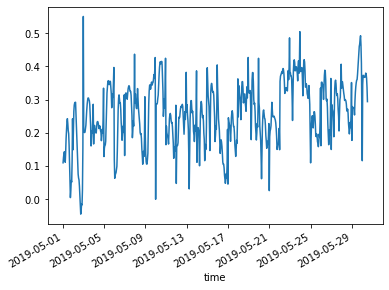

In [57]:
xr.corr(ds.EMISSIONS_2019, ds.NO_tc, dim=['latitude', 'longitude']).plot()

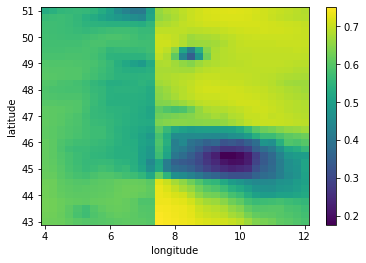

In [58]:
xr.corr(ds.EMISSIONS_2019, ds.NO_tc, dim='time').plot()

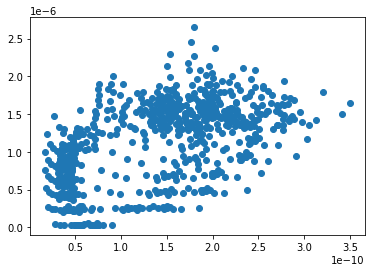

In [46]:
plt.scatter(df.EMISSIONS_2019, df.NO_tc)

In [47]:
from sklearn.metrics import r2_score

In [48]:
pearsonr(df.EMISSIONS_2019, df.NO_tc)

(0.540880777024546, 4.8414436097473134e-55)

In [59]:
from scipy.stats import linregress

In [60]:
linregress(ds.NO_tc.mean(['latitude', 'longitude']), ds.EMISSIONS_2019.mean(['latitude', 'longitude']))

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [67]:
regr = linregress(df.NO_tc, df.EMISSIONS_2019)

In [68]:
from sklearn.linear_model import LinearRegression

In [69]:
regr = LinearRegression()

In [76]:
regr.fit(list(df.NO_tc), df.EMISSIONS_2019)

ValueError: Expected 2D array, got 1D array instead:
array=[3.17951456e-07 5.59457773e-07 8.01045227e-07 1.04263268e-06
 1.28422014e-06 1.52580759e-06 1.60058718e-06 1.67536678e-06
 1.75014637e-06 1.82492597e-06 1.89970556e-06 1.97448515e-06
 1.87775350e-06 1.78102184e-06 1.68429018e-06 1.58755852e-06
 1.49082686e-06 1.39409520e-06 1.16956660e-06 9.45037998e-07
 7.20509396e-07 4.95980795e-07 2.71452193e-07 4.69235919e-08
 2.71638441e-07 4.96353290e-07 7.21068139e-07 9.45782988e-07
 1.17049784e-06 1.39521269e-06 1.49659502e-06 1.59797735e-06
 1.69935968e-06 1.80074201e-06 1.90212434e-06 2.00350667e-06
 1.89477292e-06 1.78603918e-06 1.67730544e-06 1.56857169e-06
 1.45983795e-06 1.35110420e-06 1.13195978e-06 9.12815348e-07
 6.93670920e-07 4.74526491e-07 2.55382063e-07 3.62376346e-08
 2.42073821e-07 4.47910007e-07 6.53746193e-07 8.59582379e-07
 1.06541856e-06 1.27125475e-06 1.40083719e-06 1.53041963e-06
 1.66000206e-06 1.78958450e-06 1.91916694e-06 2.04874938e-06
 1.92488186e-06 1.80101435e-06 1.67714684e-06 1.55327932e-06
 1.42941181e-06 1.30554429e-06 1.09497403e-06 8.84403770e-07
 6.73833508e-07 4.63263246e-07 2.52692984e-07 4.21227215e-08
 2.49478940e-07 4.56835159e-07 6.64191378e-07 8.71547597e-07
 1.07890382e-06 1.28626003e-06 1.43435290e-06 1.58244577e-06
 1.73053863e-06 1.87863150e-06 2.02672436e-06 2.17481723e-06
 2.03559575e-06 1.89637428e-06 1.75715280e-06 1.61793133e-06
 1.47870985e-06 1.33948837e-06 1.12240413e-06 9.05319881e-07
 6.88235635e-07 4.71151388e-07 2.54067141e-07 3.69828946e-08
 2.51842502e-07 4.66702110e-07 6.81561717e-07 8.96421325e-07
 1.11128093e-06 1.32614054e-06 1.46978582e-06 1.61343110e-06
 1.75707638e-06 1.90072166e-06 2.04436694e-06 2.18801221e-06
 2.04652069e-06 1.90502917e-06 1.76353765e-06 1.62204613e-06
 1.48055461e-06 1.33906309e-06 1.12186552e-06 9.04667940e-07
 6.87470364e-07 4.70272788e-07 2.53075211e-07 3.58776350e-08
 2.58082319e-07 4.80287003e-07 7.02491687e-07 9.24696371e-07
 1.14690105e-06 1.36910574e-06 1.47532251e-06 1.58153928e-06
 1.68775605e-06 1.79397282e-06 1.90018959e-06 2.00640636e-06
 1.89345695e-06 1.78050755e-06 1.66755814e-06 1.55460874e-06
 1.44165933e-06 1.32870993e-06 1.11405269e-06 8.99395451e-07
 6.84738211e-07 4.70080972e-07 2.55423733e-07 4.07664933e-08
 2.45655489e-07 4.50544485e-07 6.55433481e-07 8.60322476e-07
 1.06521147e-06 1.27010047e-06 1.35116014e-06 1.43221981e-06
 1.51327948e-06 1.59433915e-06 1.67539882e-06 1.75645849e-06
 1.66815949e-06 1.57986049e-06 1.49156149e-06 1.40326250e-06
 1.31496350e-06 1.22666450e-06 1.02794263e-06 8.29220754e-07
 6.30498883e-07 4.31777011e-07 2.33055139e-07 3.43332677e-08
 2.10220957e-07 3.86108647e-07 5.61996337e-07 7.37884026e-07
 9.13771716e-07 1.08965941e-06 1.19983680e-06 1.31001419e-06
 1.42019157e-06 1.53036896e-06 1.64054635e-06 1.75072374e-06
 1.66674722e-06 1.58277069e-06 1.49879416e-06 1.41481763e-06
 1.33084110e-06 1.24686457e-06 1.04483151e-06 8.42798456e-07
 6.40765399e-07 4.38732342e-07 2.36699284e-07 3.46662269e-08
 2.21861739e-07 4.09057251e-07 5.96252763e-07 7.83448275e-07
 9.70643787e-07 1.15783930e-06 1.26671350e-06 1.37558770e-06
 1.48446190e-06 1.59333610e-06 1.70221030e-06 1.81108450e-06
 1.72243686e-06 1.63378922e-06 1.54514158e-06 1.45649395e-06
 1.36784631e-06 1.27919867e-06 1.07167152e-06 8.64144373e-07
 6.56617225e-07 4.49090076e-07 2.41562928e-07 3.40357793e-08
 2.32052110e-07 4.30068441e-07 6.28084772e-07 8.26101103e-07
 1.02411743e-06 1.22213376e-06 1.30869704e-06 1.39526031e-06
 1.48182358e-06 1.56838685e-06 1.65495012e-06 1.74151339e-06
 1.65970345e-06 1.57789350e-06 1.49608356e-06 1.41427362e-06
 1.33246368e-06 1.25065374e-06 1.04858202e-06 8.46510311e-07
 6.44438599e-07 4.42366887e-07 2.40295175e-07 3.82234625e-08
 2.41857491e-07 4.45491520e-07 6.49125548e-07 8.52759577e-07
 1.05639361e-06 1.26002763e-06 1.40875509e-06 1.55748255e-06
 1.70621001e-06 1.85493747e-06 2.00366493e-06 2.15239239e-06
 2.03354669e-06 1.91470100e-06 1.79585530e-06 1.67700960e-06
 1.55816391e-06 1.43931821e-06 1.20515851e-06 9.70998810e-07
 7.36839110e-07 5.02679411e-07 2.68519711e-07 3.43600109e-08
 2.62179653e-07 4.89999296e-07 7.17818938e-07 9.45638581e-07
 1.17345822e-06 1.40127787e-06 1.49030162e-06 1.57932537e-06
 1.66834913e-06 1.75737288e-06 1.84639664e-06 1.93542039e-06
 1.82849931e-06 1.72157824e-06 1.61465716e-06 1.50773608e-06
 1.40081500e-06 1.29389392e-06 1.08699797e-06 8.80102021e-07
 6.73206071e-07 4.66310121e-07 2.59414171e-07 5.25182207e-08
 2.74977930e-07 4.97437639e-07 7.19897348e-07 9.42357057e-07
 1.16481677e-06 1.38727647e-06 1.47270124e-06 1.55812600e-06
 1.64355077e-06 1.72897553e-06 1.81440029e-06 1.89982506e-06
 1.80941380e-06 1.71900254e-06 1.62859128e-06 1.53818003e-06
 1.44776877e-06 1.35735751e-06 1.13718830e-06 9.17019092e-07
 6.96849882e-07 4.76680673e-07 2.56511463e-07 3.63422534e-08
 2.60311077e-07 4.84279900e-07 7.08248723e-07 9.32217546e-07
 1.15618637e-06 1.38015519e-06 1.46019457e-06 1.54023394e-06
 1.62027331e-06 1.70031269e-06 1.78035206e-06 1.86039144e-06
 1.76235489e-06 1.66431834e-06 1.56628179e-06 1.46824524e-06
 1.37020869e-06 1.27217214e-06 1.06604616e-06 8.59920169e-07
 6.53794184e-07 4.47668198e-07 2.41542212e-07 3.54162263e-08
 2.36979354e-07 4.38542481e-07 6.40105608e-07 8.41668736e-07
 1.04323186e-06 1.24479499e-06 1.32506072e-06 1.40532644e-06
 1.48559217e-06 1.56585790e-06 1.64612362e-06 1.72638935e-06
 1.65215788e-06 1.57792642e-06 1.50369495e-06 1.42946348e-06
 1.35523202e-06 1.28100055e-06 1.07358148e-06 8.66162416e-07
 6.58743350e-07 4.51324284e-07 2.43905217e-07 3.64861511e-08
 2.45484933e-07 4.54483714e-07 6.63482496e-07 8.72481278e-07
 1.08148006e-06 1.29047884e-06 1.37491862e-06 1.45935840e-06
 1.54379817e-06 1.62823795e-06 1.71267773e-06 1.79711750e-06
 1.71776914e-06 1.63842078e-06 1.55907242e-06 1.47972406e-06
 1.40037570e-06 1.32102735e-06 1.10709221e-06 8.93157084e-07
 6.79221953e-07 4.65286823e-07 2.51351692e-07 3.74165615e-08
 2.48670092e-07 4.59923623e-07 6.71177154e-07 8.82430685e-07
 1.09368422e-06 1.30493775e-06 1.38918392e-06 1.47343010e-06
 1.55767627e-06 1.64192245e-06 1.72616863e-06 1.81041480e-06
 1.72201837e-06 1.63362193e-06 1.54522549e-06 1.45682906e-06
 1.36843262e-06 1.28003618e-06 1.07347351e-06 8.66910841e-07
 6.60348169e-07 4.53785498e-07 2.47222826e-07 4.06601547e-08
 2.42721311e-07 4.44782467e-07 6.46843624e-07 8.48904780e-07
 1.05096594e-06 1.25302709e-06 1.33040374e-06 1.40778038e-06
 1.48515703e-06 1.56253367e-06 1.63991032e-06 1.71728697e-06
 1.64783426e-06 1.57838156e-06 1.50892886e-06 1.43947616e-06
 1.37002346e-06 1.30057076e-06 1.09503768e-06 8.89504609e-07
 6.83971533e-07 4.78438457e-07 2.72905381e-07 6.73723046e-08
 2.84412280e-07 5.01452256e-07 7.18492232e-07 9.35532208e-07
 1.15257218e-06 1.36961216e-06 1.46619904e-06 1.56278592e-06
 1.65937280e-06 1.75595967e-06 1.85254655e-06 1.94913343e-06
 1.86529387e-06 1.78145431e-06 1.69761475e-06 1.61377519e-06
 1.52993564e-06 1.44609608e-06 1.21159775e-06 9.77099428e-07
 7.42601103e-07 5.08102779e-07 2.73604454e-07 3.91061298e-08
 2.73393847e-07 5.07681565e-07 7.41969283e-07 9.76257001e-07
 1.21054472e-06 1.44483244e-06 1.54788339e-06 1.65093434e-06
 1.75398529e-06 1.85703625e-06 1.96008720e-06 2.06313815e-06
 1.96568719e-06 1.86823624e-06 1.77078528e-06 1.67333432e-06
 1.57588337e-06 1.47843241e-06 1.23815376e-06 9.97875110e-07
 7.57596461e-07 5.17317812e-07 2.77039163e-07 3.67605145e-08
 2.97718987e-07 5.58677460e-07 8.19635933e-07 1.08059441e-06
 1.34155288e-06 1.60251135e-06 1.68258482e-06 1.76265829e-06
 1.84273176e-06 1.92280523e-06 2.00287870e-06 2.08295217e-06
 1.97486996e-06 1.86678774e-06 1.75870552e-06 1.65062330e-06
 1.54254108e-06 1.43445886e-06 1.20151631e-06 9.68573759e-07
 7.35631207e-07 5.02688655e-07 2.69746103e-07 3.68035505e-08
 2.78424154e-07 5.20044757e-07 7.61665360e-07 1.00328596e-06
 1.24490657e-06 1.48652717e-06 1.56375284e-06 1.64097850e-06
 1.71820417e-06 1.79542983e-06 1.87265550e-06 1.94988117e-06
 1.85982915e-06 1.76977713e-06 1.67972510e-06 1.58967308e-06
 1.49962106e-06 1.40956904e-06 1.18827875e-06 9.66988447e-07
 7.45698149e-07 5.24407851e-07 3.03117552e-07 8.18272543e-08
 3.13205270e-07 5.44583286e-07 7.75961301e-07 1.00733932e-06
 1.23871733e-06 1.47009535e-06 1.51532615e-06 1.56055695e-06
 1.60578775e-06 1.65101855e-06 1.69624935e-06 1.74148015e-06
 1.67634362e-06 1.61120708e-06 1.54607055e-06 1.48093401e-06
 1.41579747e-06 1.35066094e-06 1.13872832e-06 9.26795698e-07
 7.14863078e-07 5.02930458e-07 2.90997838e-07 7.90652183e-08
 2.83756231e-07 4.88447243e-07 6.93138255e-07 8.97829268e-07
 1.10252028e-06 1.30721129e-06 1.36348571e-06 1.41976013e-06
 1.47603455e-06 1.53230897e-06 1.58858339e-06 1.64485781e-06
 1.58925471e-06 1.53365160e-06 1.47804850e-06 1.42244540e-06
 1.36684229e-06 1.31123919e-06 1.10068302e-06 8.90126849e-07
 6.79570678e-07 4.69014507e-07 2.58458336e-07 4.79021646e-08
 2.64662327e-07 4.81422490e-07 6.98182652e-07 9.14942815e-07
 1.13170298e-06 1.34846314e-06 1.42192496e-06 1.49538679e-06
 1.56884861e-06 1.64231044e-06 1.71577226e-06 1.78923409e-06
 1.72102160e-06 1.65280912e-06 1.58459663e-06 1.51638415e-06
 1.44817166e-06 1.37995917e-06 1.15693416e-06 9.33909146e-07
 7.10884132e-07 4.87859118e-07 2.64834104e-07 4.18090896e-08
 2.56135329e-07 4.70461568e-07 6.84787807e-07 8.99114046e-07
 1.11344028e-06 1.32776652e-06 1.39773844e-06 1.46771035e-06
 1.53768226e-06 1.60765417e-06 1.67762608e-06 1.74759800e-06
 1.67709459e-06 1.60659118e-06 1.53608777e-06 1.46558436e-06
 1.39508096e-06 1.32457755e-06 1.10990966e-06 8.95241772e-07
 6.80573884e-07 4.65905996e-07 2.51238108e-07 3.65702199e-08
 2.35719162e-07 4.34868104e-07 6.34017046e-07 8.33165988e-07
 1.03231493e-06 1.23146387e-06 1.32694065e-06 1.42241743e-06
 1.51789422e-06 1.61337100e-06 1.70884778e-06 1.80432456e-06
 1.71978388e-06 1.63524319e-06 1.55070251e-06 1.46616182e-06
 1.38162114e-06 1.29708046e-06 1.08892506e-06 8.80769657e-07
 6.72614257e-07 4.64458857e-07 2.56303457e-07 4.81480571e-08
 2.45226122e-07 4.42304187e-07 6.39382252e-07 8.36460317e-07
 1.03353838e-06 1.23061645e-06 1.34570397e-06 1.46079149e-06
 1.57587901e-06 1.69096653e-06 1.80605405e-06 1.92114157e-06
 1.83803428e-06 1.75492700e-06 1.67181971e-06 1.58871243e-06
 1.50560514e-06 1.42249786e-06 1.19164571e-06 9.60793558e-07
 7.29941409e-07 4.99089260e-07 2.68237111e-07 3.73849627e-08
 2.70472150e-07 5.03559337e-07 7.36646525e-07 9.69733712e-07
 1.20282090e-06 1.43590809e-06 1.50453562e-06 1.57316315e-06
 1.64179068e-06 1.71041822e-06 1.77904575e-06 1.84767328e-06
 1.75998716e-06 1.67230105e-06 1.58461493e-06 1.49692881e-06
 1.40924270e-06 1.32155658e-06 1.10845024e-06 8.95343893e-07
 6.82237550e-07 4.69131207e-07 2.56024864e-07 4.29185215e-08
 2.63494084e-07 4.84069647e-07 7.04645210e-07 9.25220772e-07
 1.14579634e-06 1.36637190e-06 1.42927668e-06 1.49218146e-06
 1.55521748e-06 1.61815141e-06 1.68108534e-06 1.74401926e-06].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.